<h2>Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

import dask
import time

import cudf
import cuml
import cupy as cp

import os, wget

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

import celltypist

from dask_cuda import initialize, LocalCUDACluster
from dask.distributed import Client, default_client

from matplotlib.pyplot import rc_context

import rapids_scanpy_funcs
import utils

import logging
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

sc.settings.n_jobs = 200

cuml.__version__

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'23.02.00'

<h2>Setting up multi gpu use

In [2]:
import rmm

def set_mem():
    rmm.reinitialize(managed_memory=True)
    cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

In [3]:
preprocessing_gpus=[0, 1, 2, 3]

In [4]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=preprocessing_gpus)
client = Client(cluster)    

set_mem()
client.run(set_mem)

client

To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
State start
  Scheduler at:     tcp://127.0.0.1:43475
  dashboard at:            127.0.0.1:8787
        Start Nanny at: 'tcp://127.0.0.1:46269'
        Start Nanny at: 'tcp://127.0.0.1:42935'
        Start Nanny at: 'tcp://127.0.0.1:36009'
        Start Nanny at: 'tcp://127.0.0.1:42845'
        Start Nanny at: 'tcp://127.0.0.1:35641'
        Start Nanny at: 'tcp://127.0.0.1:43755'
        Start Nanny at: 'tcp://127.0.0.1:38983'
2023-05-18 15:44:37,474 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-18 15:44:37,474 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-18 15:44:37,483 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-18 15:44:37,483 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-18 15:44:37,501 - distributed.preloadin

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 7,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43475,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 7
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:46311,Total threads: 1
Dashboard: http://127.0.0.1:34683/status,Memory: 143.96 GiB
Nanny: tcp://127.0.0.1:46269,


<h2>Preprocessing

<h3>Set the parameters

In [5]:
# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed

MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["CSF1", "PET100", "APOE", "APP", "KCNB1"] # Marker genes for visualization

# filtering genes
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 100 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

n_workers = len(client.scheduler_info()['workers'])

<h3>Load and Preprocess Data</h3>
Below, we load the sparse count matrix from the .h5ad file into GPU using a custom function. While reading the dataset, filters are applied on the count matrix to remove cells with an extreme number of genes expressed. Genes will zero expression in all cells are also eliminated.

The custom function uses Dask to partition data. The above mentioned filters are applied on individual partitions. Usage of Dask along with cupy provides the following benefits:

    Parallelized data loading when multiple GPUs are available
    Ability to partition the data allows pre-processing large datasets

Filters are applied on individual batches of cells. Elementwise or cell-level normalization operations are also performed while reading. For this example, the following two operations are performed:

    Normalize the count matrix so that the total counts in each cell sum to 1e4.
    Log transform the count matrix.



In [6]:
'''ad = sc.read_h5ad("data/SEAAD_MTG_RNAseq_all-nuclei.2022-08-18.h5ad", backed="r")

set_cells = list()
chunk_size = 10000
for chunk, start, end in ad.chunked_X(chunk_size):
    subset_min, _ = sc.pp.filter_cells(anndata.AnnData(chunk), min_genes=min_genes_per_cell, inplace=False)
    subset_max, _ = sc.pp.filter_cells(anndata.AnnData(chunk), max_genes=max_genes_per_cell, inplace=False)
    set_cells = set_cells + list(subset_max * subset_min)
obs = pd.read_csv("data/obs_all-nuclei.2022-08-18.csv")
obs["set_cells"] = set_cells
obs = obs.drop(obs[obs.set_cells == False].index)'''

'ad = sc.read_h5ad("data/SEAAD_MTG_RNAseq_all-nuclei.2022-08-18.h5ad", backed="r")\n\nset_cells = list()\nchunk_size = 10000\nfor chunk, start, end in ad.chunked_X(chunk_size):\n    subset_min, _ = sc.pp.filter_cells(anndata.AnnData(chunk), min_genes=min_genes_per_cell, inplace=False)\n    subset_max, _ = sc.pp.filter_cells(anndata.AnnData(chunk), max_genes=max_genes_per_cell, inplace=False)\n    set_cells = set_cells + list(subset_max * subset_min)\nobs = pd.read_csv("data/obs_all-nuclei.2022-08-18.csv")\nobs["set_cells"] = set_cells\nobs = obs.drop(obs[obs.set_cells == False].index)'

In [7]:
%%time
def partial_post_processor(partial_data):
    partial_data = rapids_scanpy_funcs.normalize_total(partial_data, target_sum=1e4)
    return partial_data.log1p()

dask_sparse_arr, genes, query = rapids_scanpy_funcs.read_with_filter(client,
                                                       "data/SEAAD_MTG_RNAseq_all-nuclei.2022-08-18.h5ad",
                                                       min_genes_per_cell=min_genes_per_cell,
                                                       max_genes_per_cell=max_genes_per_cell,
                                                       partial_post_processor=partial_post_processor)
dask_sparse_arr = dask_sparse_arr.persist()

CPU times: user 8.13 s, sys: 4.92 s, total: 13 s
Wall time: 1min 48s


Verify the shape of the resulting sparse matrix:

In [8]:
dask_sparse_arr.shape

(1957283, 35989)


<h3>Select Most Variable Genes</h3>

Before filtering the count matrix, we save the 'raw' expression values of the marker genes to use for labeling cells afterward.


In [9]:
%%time
marker_genes_raw = {}
i = 0
for index in genes[genes.isin(markers)].index.to_arrow().to_pylist():
    marker_genes_raw[markers[i]] = dask_sparse_arr[:, index].compute().toarray().ravel()
    i += 1

CPU times: user 11.5 s, sys: 1.16 s, total: 12.7 s
Wall time: 25.5 s


Filter the count matrix to retain only the most variable genes.

In [10]:
%%time

hvg = rapids_scanpy_funcs.highly_variable_genes_filter(client, dask_sparse_arr, genes, n_top_genes=n_top_genes)

genes = genes[hvg]
dask_sparse_arr = dask_sparse_arr[:, hvg]
sparse_gpu_array = dask_sparse_arr.compute()


CPU times: user 4.67 s, sys: 3.62 s, total: 8.29 s
Wall time: 12.3 s


In [11]:
adata = anndata.AnnData(X=dask_sparse_arr.compute().get())
adata.var_names = genes.to_numpy()

In [12]:
adata.raw = adata

In [13]:
import celltypist

In [14]:
celltypist.models.download_models(model = 'Immune_All_High.pkl')

📂 Storing models in /root/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_High.pkl (file exists)


In [15]:
adata = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = False).to_adata()

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 1260769 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 1441 features used for prediction
⚖️ Scaling input data
Event loop was unresponsive in Nanny for 12.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 12.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 12.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 12.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can caus

In [16]:
adata.obs[['predicted_labels', 'conf_score']]

,predicted_labels,conf_score
0,Endothelial cells,1.000000
1,Epithelial cells,1.000000
2,Epithelial cells,0.999979
3,Epithelial cells,0.999960
4,Double-positive thymocytes,0.997688
...,...,...
1260764,Double-positive thymocytes,0.901729
1260765,Epithelial cells,1.000000
1260766,Fibroblasts,0.999885
1260767,DC,0.668309


In [17]:
predicted_labels = list(adata.obs.predicted_labels)
conf_score = list(adata.obs.conf_score)


<h3>Regress out confounding factors (number of counts, mitochondrial gene expression)</h3>

We can now perform regression on the count matrix to correct for confounding factors - for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with mt-).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.


In [18]:
%%time
sparse_gpu_array = sparse_gpu_array.tocsc()

mito_genes = genes.str.startswith(MITO_GENE_PREFIX).values
n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 3 s, sys: 600 ms, total: 3.6 s
Wall time: 3.35 s


In [19]:
del sparse_gpu_array

And perform regression:

In [20]:
%%time
n_rows = dask_sparse_arr.shape[0]
n_cols = dask_sparse_arr.shape[1]
cols_per_worker = int(n_cols / n_workers)
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: x.todense(), dtype="float32", meta=cp.array(cp.zeros((0,)))).T
dask_sparse_arr = dask_sparse_arr.rechunk((cols_per_worker, n_rows)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 729 ms, sys: 1 s, total: 1.73 s
Wall time: 19.6 s


dask.array<rechunk-merge, shape=(4000, 1260769), dtype=float32, chunksize=(571, 1260769), chunktype=cupy.ndarray>

In [21]:
%%time
import math
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: rapids_scanpy_funcs.regress_out(x.T, n_counts, percent_mito).T, dtype="float32", meta=cp.array(cp.zeros(0,))).T
dask_sparse_arr = dask_sparse_arr.rechunk((math.ceil(n_rows/n_workers), n_cols)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 664 ms, sys: 1.09 s, total: 1.75 s
Wall time: 13.7 s


dask.array<rechunk-merge, shape=(1260769, 4000), dtype=float32, chunksize=(279612, 4000), chunktype=cupy.ndarray>


<h3>Scale</h3>

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.


In [22]:
%%time
mean = dask_sparse_arr.mean(axis=0)
dask_sparse_arr -= mean
stddev = cp.sqrt(dask_sparse_arr.var(axis=0).compute())
dask_sparse_arr /= stddev
dask_sparse_arr = dask.array.clip(dask_sparse_arr, -10, 10).persist()

del mean, stddev

CPU times: user 471 ms, sys: 586 ms, total: 1.06 s
Wall time: 9.92 s


<h2>Cluster & Visualize


<h3>Reduce</h3>

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.


In [23]:
%%time
from cuml.dask.decomposition import PCA
pca_data = PCA(n_components=50).fit_transform(dask_sparse_arr)
pca_data.compute_chunk_sizes()

Run out-of-band function '_func_set_scheduler_as_nccl_root'
Run out-of-band function '_func_destroy_scheduler_session'


CPU times: user 492 ms, sys: 548 ms, total: 1.04 s
Wall time: 9.23 s


dask.array<concatenate, shape=(1260769, 50), dtype=float32, chunksize=(279612, 50), chunktype=cupy.ndarray>

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [24]:
%%time
local_pca = pca_data.compute()
X = dask_sparse_arr.compute().get()

Event loop was unresponsive in Nanny for 9.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 9.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 9.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 9.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 9.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 9.42s.  This is often caused by long-running GIL-h

CPU times: user 17.9 s, sys: 4min 38s, total: 4min 56s
Wall time: 4min 47s


In [25]:
%%time
adata = anndata.AnnData(X=X)
adata.var_names = genes.to_numpy()
adata.obsm["X_pca"] = local_pca.get()
obs = pd.read_csv("data/set_cell-obs_all-nuclei.2022-08-18.csv")
adata.obs = obs
adata.obs.drop(columns = ["Unnamed: 0", "Unnamed: 0.1"])
adata.obs["predicted_labels"] =  predicted_labels
adata.obs["conf_score"] = conf_score

del obs
del predicted_labels
del conf_score
del pca_data
del dask_sparse_arr

CPU times: user 11 s, sys: 1.42 s, total: 12.5 s
Wall time: 11.7 s


In [94]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

Event loop was unresponsive in Nanny for 27.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 27.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 27.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 27.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 27.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 27.73s.  This is often caused by long-running

CPU times: user 1min 11s, sys: 3.35 s, total: 1min 14s
Wall time: 1min 3s


In [95]:
%%time
sc.tl.louvain(adata, flavor='rapids')

Event loop was unresponsive in Nanny for 25.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 25.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 25.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 25.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 25.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 25.43s.  This is often caused by long-running

CPU times: user 19.6 s, sys: 7.27 s, total: 26.8 s
Wall time: 26.6 s


In [96]:
# compute clusters using the leiden method and store the results with the name `clusters`
clusters = rapids_scanpy_funcs.leiden(adata, resolution=0.4)
adata.obs["leiden"] = clusters
del clusters

In [97]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

Event loop was unresponsive in Nanny for 37.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 37.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 37.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 37.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 37.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 37.81s.  This is often caused by long-running GIL

CPU times: user 37.5 s, sys: 454 ms, total: 37.9 s
Wall time: 37.8 s


Event loop was unresponsive in Scheduler for 37.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


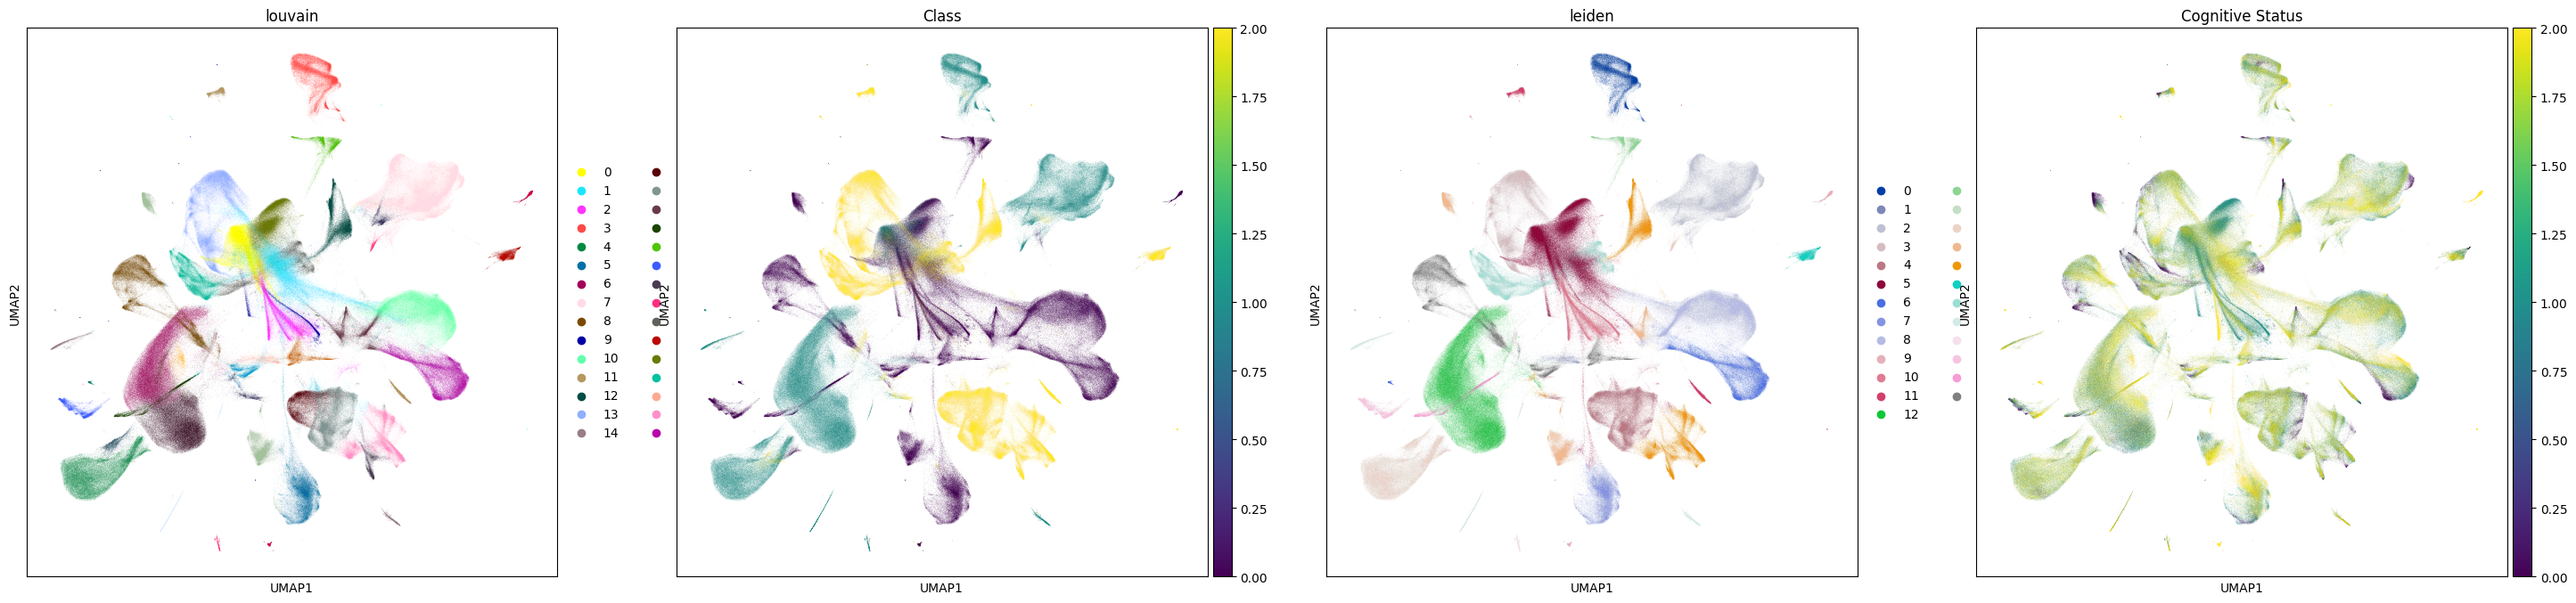

CPU times: user 26.9 s, sys: 3.27 s, total: 30.2 s
Wall time: 27 s


In [98]:
%%time
with rc_context({"figure.figsize": (8, 8)}):
    sc.pl.umap(adata, color=["louvain", "Class", "leiden", "Cognitive Status"])

In [31]:
scores, names, original_reference = rapids_scanpy_funcs.rank_genes_groups(adata, "leiden")

Event loop was unresponsive in Nanny for 5.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 5.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 5.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 5.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 5.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 5.76s.  This is often caused by long-running GIL-h

[W] [16:02:04.022697] L-BFGS: max iterations reached
[W] [16:02:04.024668] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


Event loop was unresponsive in Scheduler for 45.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 45.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 45.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 45.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 45.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 45.69s.  This is often caused by long-running

In [32]:
adata.uns["rank_scores"] = scores
adata.uns["names"] = names

del scores, names, original_reference

In [35]:
alignment = celltypist.harmonize(adata, 'Class', 'predicted_labels')

👀 Detected PCA coordinates in the object, will use these to calculate distances
🏆 Reordering datasets
🖇 Harmonizing cell types of 0 and 2
🖇 Harmonizing cell types of 1
🖋️ Reannotating cells
✅ Harmonization done!


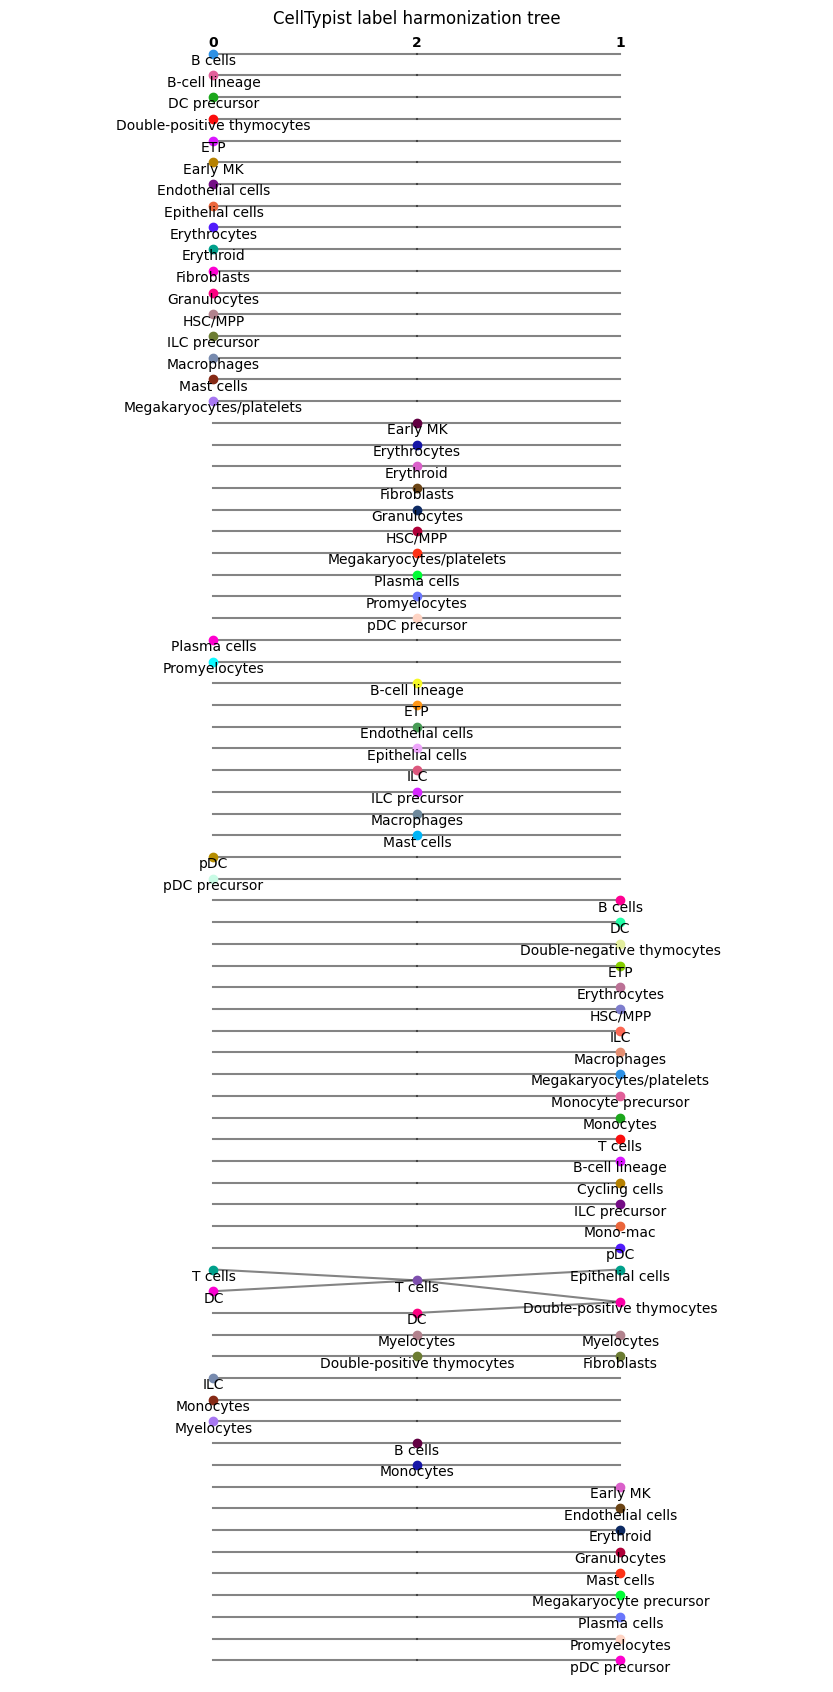

In [36]:
celltypist.treeplot(alignment)

In [37]:
adata.obs[['reannotation', 'group']] = alignment.reannotation[['reannotation', 'group']].loc[adata.obs_names]

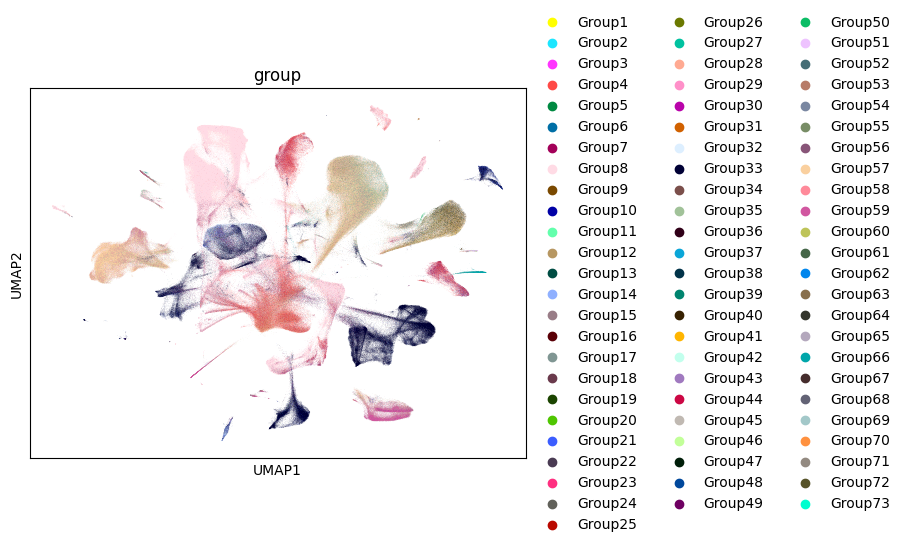

In [46]:
sc.pl.umap(adata, color = 'group')

In [39]:
adata.obs.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'APOE4 Status',
       'ATAC_Confidently_mapped_read_pairs',
       'ATAC_Fraction_of_genome_in_peaks',
       'ATAC_Fraction_of_high_quality_fragments_in_cells',
       'ATAC_Fraction_of_high_quality_fragments_overlapping_TSS',
       'ATAC_Fraction_of_high_quality_fragments_overlapping_peaks',
       'ATAC_Fraction_of_transposition_events_in_peaks_in_cells',
       'ATAC_Mean_raw_read_pairs_per_cell',
       ...
       'sample_name', 'sample_quantity_count', 'specify other race',
       'set_cells', 'predicted_labels', 'conf_score', 'louvain', 'leiden',
       'reannotation', 'group'],
      dtype='object', length=140)

In [47]:
np.unique(alignment.reannotation["group"])

array(['Group1', 'Group10', 'Group11', 'Group12', 'Group13', 'Group14',
       'Group15', 'Group16', 'Group17', 'Group18', 'Group19', 'Group2',
       'Group20', 'Group21', 'Group22', 'Group23', 'Group24', 'Group25',
       'Group26', 'Group27', 'Group28', 'Group29', 'Group3', 'Group30',
       'Group31', 'Group32', 'Group33', 'Group34', 'Group35', 'Group36',
       'Group37', 'Group38', 'Group39', 'Group4', 'Group40', 'Group41',
       'Group42', 'Group43', 'Group44', 'Group45', 'Group46', 'Group47',
       'Group48', 'Group49', 'Group5', 'Group50', 'Group51', 'Group52',
       'Group53', 'Group54', 'Group55', 'Group56', 'Group57', 'Group58',
       'Group59', 'Group6', 'Group60', 'Group61', 'Group62', 'Group63',
       'Group64', 'Group65', 'Group66', 'Group67', 'Group68', 'Group69',
       'Group7', 'Group70', 'Group71', 'Group72', 'Group73', 'Group8',
       'Group9'], dtype=object)

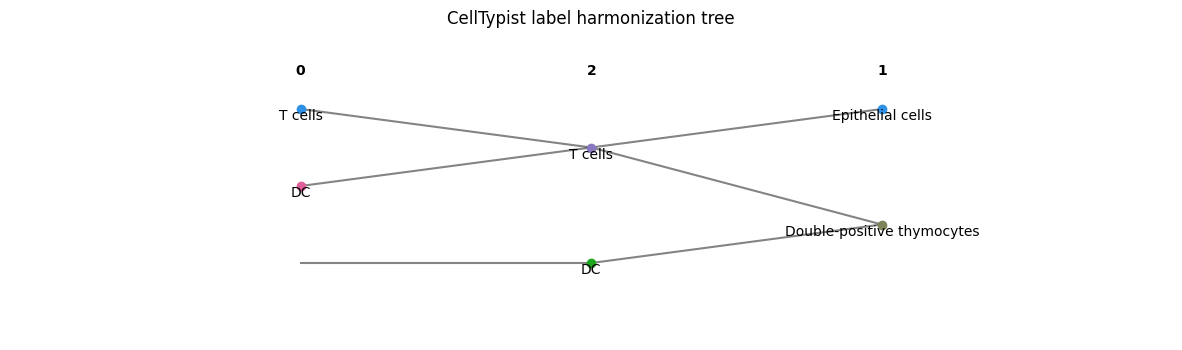

In [88]:
celltypist.treeplot(alignment.relation[alignment.groups == 'Group57'], figsize = [15, 4])#13, 44

In [89]:
low_cell_types = np.unique(adata.obs.reannotation[adata.obs.group == 'Group57'])
low_cell_types

array(['DC ∈ T cells ∈ Double-positive thymocytes',
       'NONE = DC ∈ Double-positive thymocytes',
       'T cells ∈ T cells = Epithelial cells'], dtype=object)

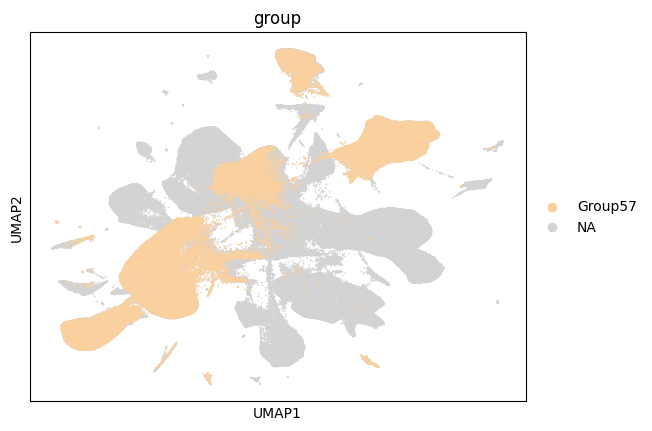

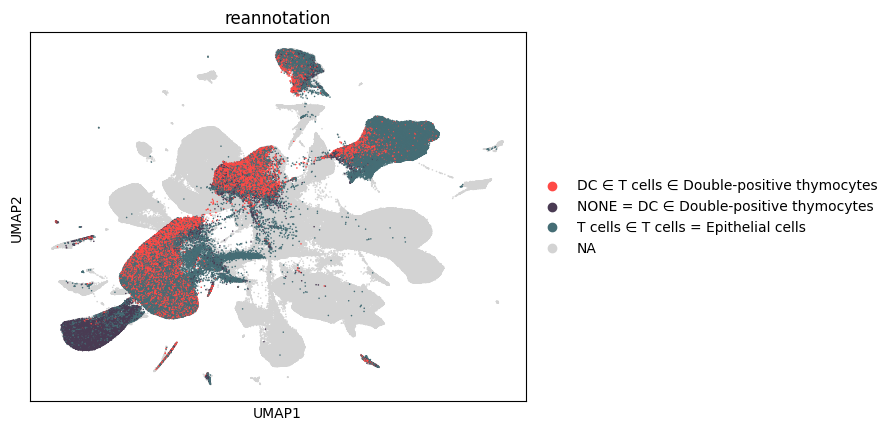

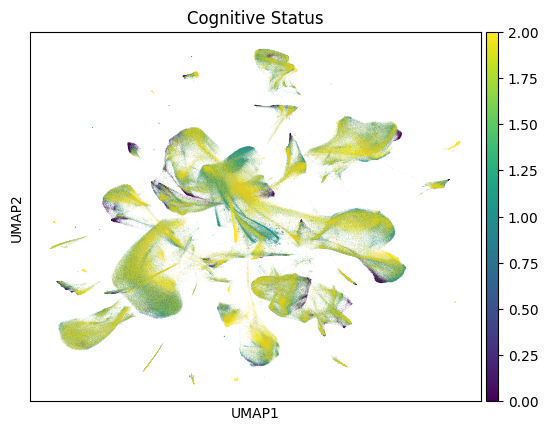

In [101]:
sc.pl.umap(adata, color = 'group', groups = 'Group57', size = 5)
sc.pl.umap(adata, color = ['reannotation'], groups = list(low_cell_types), size = 5)
sc.pl.umap(adata, color = 'Cognitive Status')

In [161]:
sc.tl.paga(adata, groups="leiden")

Event loop was unresponsive in Scheduler for 11.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 3.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [162]:
sc.pl.draw_graph(adata, color='paul15_clusters', layout=)

KeyError: 'draw_graph'

In [104]:
merfish = sc.read("data/SEAAD_MTG_MERFISH_all-nuclei.2023-05-08.h5ad")

In [136]:
merfish

AnnData object with n_obs × n_vars = 1321191 × 180
    obs: 'Donor ID', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in months', 'APOE4 Status', 'Primary Study Name', 'Secondary Study Name', 

In [134]:
merfish.obs["napari_1"]

896178    -7844.098759
222944    -4700.931450
888681    -6726.639800
1080706   -2558.165181
1310397   -2334.945750
              ...     
359783    -5497.588366
152315    -4087.289219
963395    -5741.073352
117952    -2764.825264
305711    -3270.096780
Name: napari_1, Length: 1321191, dtype: float64

full garbage collection released 1.39 GiB from 1324715 reference cycles (threshold: 9.54 MiB)
Event loop was unresponsive in Scheduler for 3.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 4.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 13.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 26.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


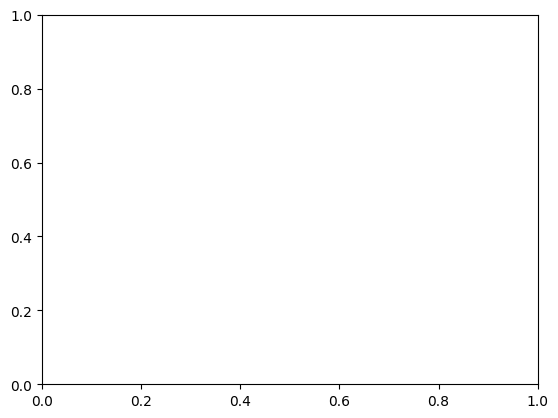

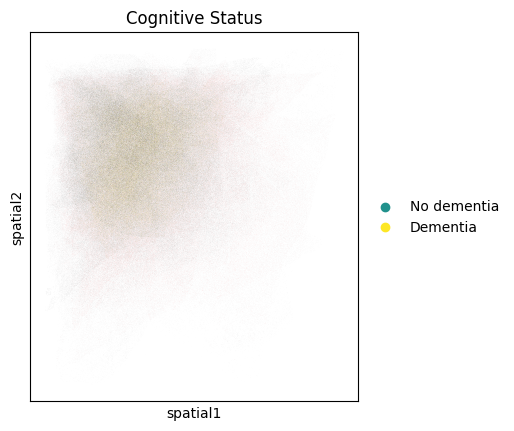

In [154]:
sc.pl.spatial(merfish, color=["Cognitive Status"], spot_size=1)

In [103]:
#adata.write("data/third_try.h5ad")

In [ ]:
#client.shutdown()
#cluster.close()